# Clustering

This part is about clustering the tweets by their embeddings using tf-idf, sentence transformers and bert CLS vectorization. We are creating 2 clusters with 2 different models (GMM and KNN) to see correlation between clusters and being from governmental party or opposition. High correlation could mean the tweets are significantly different between opposition and proposition.

## 1. Libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
import random
import numpy as np
import torch

seed = 421
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## 2. Reading data

In [13]:
df_filtered = pd.read_parquet('/Users/mateuszpliszka/Documents/GitHub/Twitter4/bez nazwy/data/03.cleaned/df_bert_values_GIT.parquet')

### CLUSTERING
#### 1. TF-IDF VECTORIZATION 
Applying tf-idf vectorization

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)

#### 2. Sentence transformer

Applying Sentence transformer vectorization

In [15]:
from sentence_transformers import SentenceTransformer
import numpy as np
import time

st = time.time()

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
df_filtered['encode_transforemers'] = df_filtered['text_clean_en_demojized'].apply(lambda text: model.encode(text, convert_to_numpy=True).flatten())

et = time.time()

print("Elapsed time: {:.2f} seconds".format(et - st))



README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

Elapsed time: 4146.57 seconds


#### Bert CLS model

Applying Bert CLS vectorization

In [17]:
from transformers import BertTokenizer, BertModel
import torch
import time

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

def get_cls_sentence(sentence):
    input_ids = torch.tensor([tokenizer.encode(sentence, add_special_tokens=True, max_length=512)])

    with torch.no_grad():
        outputs = model(input_ids)
        cls_embedding = outputs[0][:, 0, :]
    
    return cls_embedding.flatten()

st = time.time()

df_filtered['cls_bert'] = df_filtered['text_clean_en_demojized'].apply(lambda sentence: get_cls_sentence(sentence))

et = time.time()

print("Elapsed time: {:.2f} seconds".format(et - st))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Elapsed time: 3211.51 seconds


In [23]:
df_filtered.to_pickle('/Users/mateuszpliszka/Documents/GitHub/Twitter4/bez nazwy/data/03.cleaned/df_vectorizations.pkl')

In [4]:
df_filtered = pd.read_pickle('/Users/mateuszpliszka/Documents/GitHub/Twitter4/bez nazwy/data/03.cleaned/df_vectorizations.pkl')

In [7]:
X = vectorizer.fit_transform(df_filtered['text_clean_en_demojized']).toarray()
X_transformers = np.vstack(df_filtered['encode_transforemers'])
X_cls_bert = np.vstack(df_filtered['cls_bert'])

#### K-means clustering

Creating 2 clusters of tweets to check correlation between clusters and parties belonging (or not) to ruling majority. Firstly, with k-means algorithm.

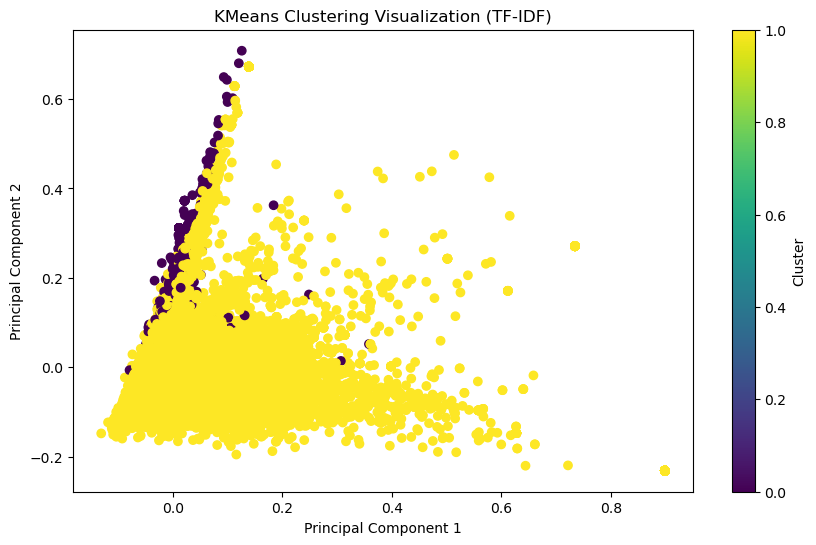

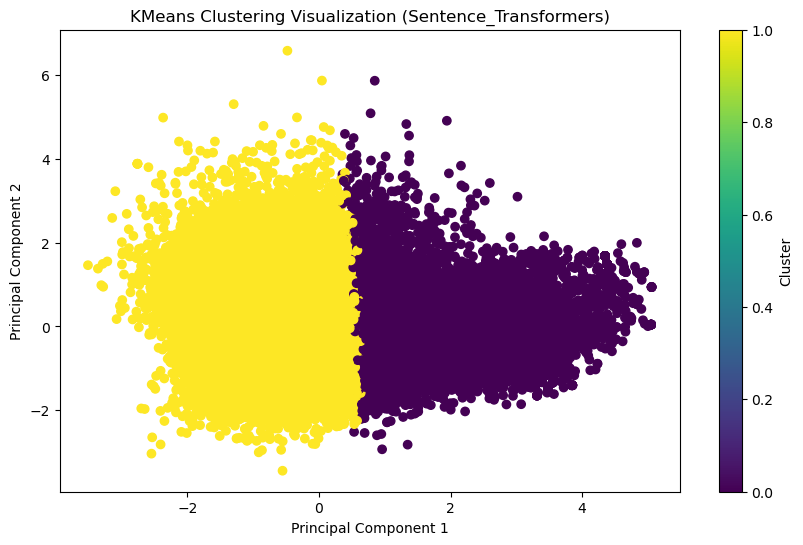

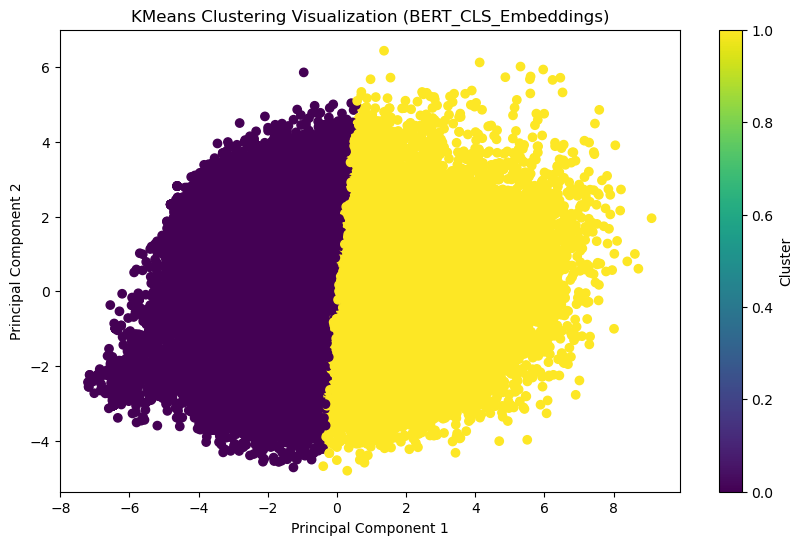

In [8]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt

def kmeans_clustering_and_visualization(data, num_clusters=2, title=''):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(data)
    df_filtered.loc[:, f'cluster_knn{title}'] = clusters
    pca = PCA(n_components=2)
    principal_components = pca.fit_transform(data)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(principal_components[:, 0], principal_components[:, 1], c=clusters, cmap='viridis', marker='o')
    plt.title(f'KMeans Clustering Visualization ({title})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(label='Cluster')
    plt.show()

kmeans_clustering_and_visualization(X, num_clusters=2, title='TF-IDF')

kmeans_clustering_and_visualization(X_transformers, num_clusters=2, title='Sentence_Transformers')

kmeans_clustering_and_visualization(X_cls_bert, num_clusters=2, title='BERT_CLS_Embeddings')

#### Gausian Mixture Model clustering

Creating two clusters of tweets with a GMM model.

In [9]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import pandas as pd

def gmm_clustering_and_visualization(data, num_clusters=2, title=''):
    # Step 1: Reduce dimensions to speed up GMM
    pca_for_gmm = PCA(n_components=min(50, data.shape[1]), random_state=42)
    data_reduced = pca_for_gmm.fit_transform(data)

    # Step 2: Fit GMM with optimized parameters
    gmm = GaussianMixture(
        n_components=num_clusters,
        covariance_type='diag',   # much faster than 'full'
        max_iter=100,
        n_init=1,
        random_state=42
    )
    clusters = gmm.fit_predict(data_reduced)

    # Step 3: Store cluster labels in DataFrame
    df_filtered.loc[:, f'cluster_gmm_{title}'] = clusters

    # Step 4: Reduce to 2D for visualization
    pca_for_plot = PCA(n_components=2, random_state=42)
    principal_components = pca_for_plot.fit_transform(data_reduced)

    # Step 5: Plot
    plt.figure(figsize=(10, 6))
    scatter = plt.scatter(
        principal_components[:, 0],
        principal_components[:, 1],
        c=clusters,
        cmap='viridis',
        marker='o',
        s=10
    )
    plt.title(f'GMM Clustering Visualization ({title})')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.colorbar(scatter, label='Cluster')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

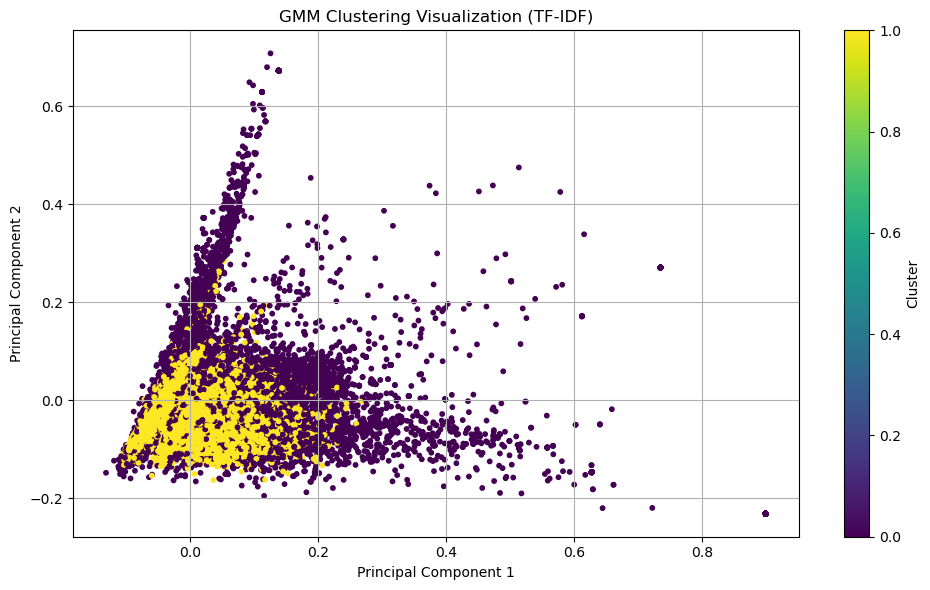

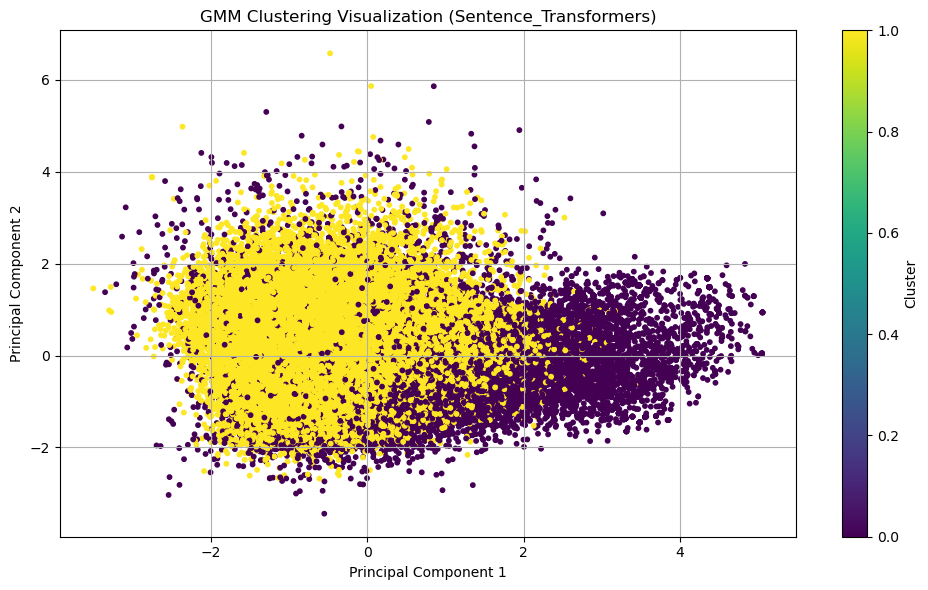

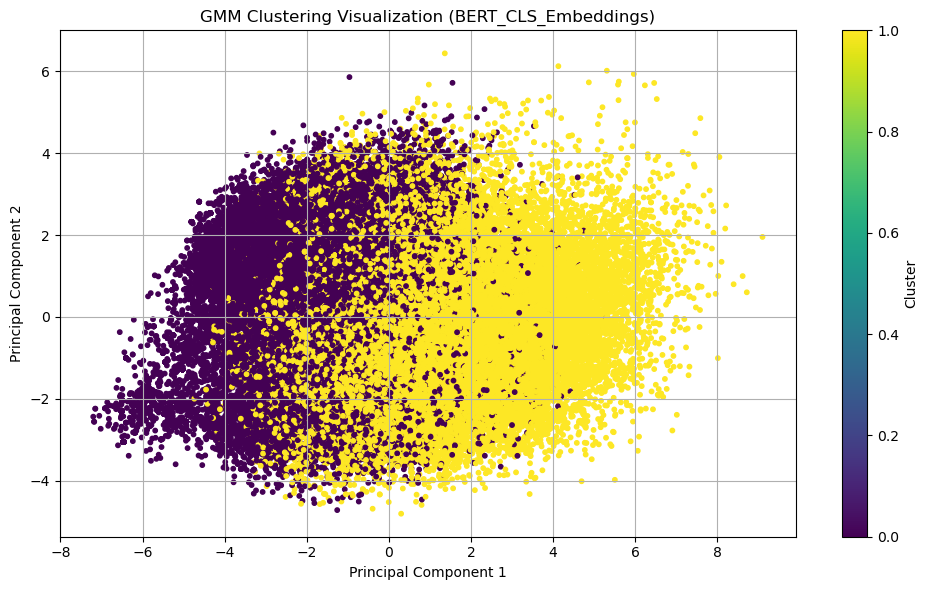

In [10]:
gmm_clustering_and_visualization(X, num_clusters=2, title='TF-IDF')
gmm_clustering_and_visualization(X_transformers, num_clusters=2, title='Sentence_Transformers')
gmm_clustering_and_visualization(X_cls_bert, num_clusters=2, title='BERT_CLS_Embeddings')

#### Correlation between clusters and being an opposition/proposition party - knn

In [11]:
df_filtered['opposition_proposition'] = df_filtered.apply(
    lambda row: (
        1 if row['created_at'] < pd.Timestamp('2023-10-15 00:00:00+00:00') and row['party'] == 'PIS'
        else 0 if row['created_at'] < pd.Timestamp('2023-10-15 00:00:00+00:00')
        else 0 if row['party'] in ['PIS', 'Konfederacja']
        else 1
    ),
    axis=1
)

# Calculate the correlation between 'opposition_proposition' and 'cluster'
correlation = df_filtered['opposition_proposition'].corr(df_filtered['cluster_knnTF-IDF'])
correlation1 = df_filtered['opposition_proposition'].corr(df_filtered['cluster_knnSentence_Transformers'])
correlation2 = df_filtered['opposition_proposition'].corr(df_filtered['cluster_knnBERT_CLS_Embeddings'])

print(f"Correlation between clusters (knn) and opposition/proposition (TF-IDF): {correlation}")
print(f"Correlation between clusters (knn) and opposition/proposition (Sentence Transformes): {correlation1}")
print(f"Correlation between clusters (knn) and opposition/proposition (BERT CLS Embeddings): {correlation2}")

Correlation between clusters (knn) and opposition/proposition (TF-IDF): -0.07109802342234103
Correlation between clusters (knn) and opposition/proposition (Sentence Transformes): -0.028055703307145546
Correlation between clusters (knn) and opposition/proposition (BERT CLS Embeddings): 0.008484535931328094


#### Correlation between clusters and being an opposition/proposition party - gmm

In [12]:
df_filtered['opposition_proposition'] = df_filtered.apply(
    lambda row: (
        1 if row['created_at'] < pd.Timestamp('2023-10-15 00:00:00+00:00') and row['party'] == 'PIS'
        else 0 if row['created_at'] < pd.Timestamp('2023-10-15 00:00:00+00:00')
        else 0 if row['party'] in ['PIS', 'Konfederacja']
        else 1
    ),
    axis=1
)

# Calculate the correlation between 'opposition_proposition' and 'cluster'
correlation_gmm_tf_idf = df_filtered['opposition_proposition'].corr(df_filtered['cluster_gmm_TF-IDF'])
correlation_gmm_sentence_transformers = df_filtered['opposition_proposition'].corr(df_filtered['cluster_gmm_Sentence_Transformers'])
correlation_gmm_bert_cls_embeddings = df_filtered['opposition_proposition'].corr(df_filtered['cluster_gmm_BERT_CLS_Embeddings'])

print(f"Correlation between GMM clusters and opposition/proposition (TF-IDF): {correlation_gmm_tf_idf}")
print(f"Correlation between GMM clusters and opposition/proposition (Sentence Transformers): {correlation_gmm_sentence_transformers}")
print(f"Correlation between GMM clusters and opposition/proposition (BERT CLS Embeddings): {correlation_gmm_bert_cls_embeddings}")

Correlation between GMM clusters and opposition/proposition (TF-IDF): -0.02255489094639426
Correlation between GMM clusters and opposition/proposition (Sentence Transformers): -0.00042834444856898685
Correlation between GMM clusters and opposition/proposition (BERT CLS Embeddings): 0.009727724755330442


The correlation values are inconclusive. To do:
 - differentiate between before and after the election

In [43]:
#df_filtered.to_pickle('cleaned_data/df_filtered.pkl')